<a href="https://colab.research.google.com/github/juanrassis/python_projects/blob/main/GeospatialAnalysis_WaterManagement_Ukraine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **OPTIMIZING WATER RESOURCES IN UKRAINE**
---


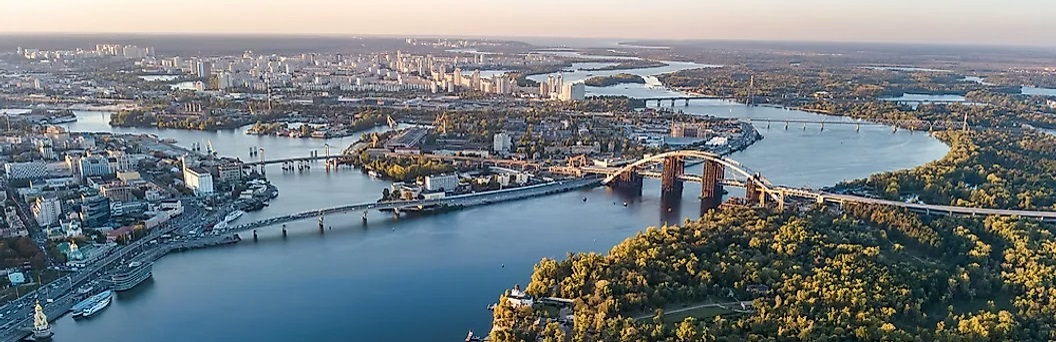

## **What to expect from this project?**

*   Data Cleaning and Pre-processing 
*   Geo-referencing and dataframe conversion
*   Multivariate Statistical Analysis
*   Geospatial Analysis

## **Context**

[TEXT HERE]

## **Table of Contents**

> 1.   **Preparation**
>>1.1   Python Libraries |
>>1.2   The Dataframe |
>>1.3   GeoJSON Basemap
> 2.   **Data Quality Check and Cleaning**
>>2.1   Diagnosticing data issues |
>>2.2   Dropping columns and rows |
>>2.3   Renaming columns
> 3.   **Geodata Pre-processing**
>>3.1   Producing Derived Data |
>>3.2   Reverse Geocoding |
>>3.3   GeoDataFrame Conversion |
>>3.4   Final Version
> 4.   **Exploration**
>>4.1   Summary Statistics |
>>4.2   Correlation Analysis
> 5.   **Regional Analysis**
>>5.1   Population Distribution |
>>5.2   Safe Water Accessibility |
>>5.2   Prioritising Regions
> 5.   **Conclusion**
> 6.   **References**

# **1.0 Preparation**
---



In this notebook I'll be using a good variety of Python libraries that can make it easier to perform complex tasks and generate data visuals. So, first I need to install some packages not pre-existent on Google Colab using a package manager ("pip" command). And once I have all those set up, I can just import them into my notebook using the import keyword, followed by the name of the library.

### 1.1 Python Libraries

In [1]:
! pip install --quiet kaggle # API to load Kaggle datasets directly into Google Colab
! pip install --quiet geopandas # library that provides a dataframe-like interface for manipulating and analysing geospatial data
! pip install --quiet squarify
! pip install --quiet https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 89.6 MB/s eta 0:00:00
     / 22.0 MB 19.4 MB/s 0:00:02
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 KB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 KB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 KB 31.4 MB/s eta 0:00:00
  Running setup.py install for pandas-profiling ... done
  DEPRECATION: pandas-profiling was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue

In [2]:
# DATA PROCESSING
import pandas as pd # read csv file as a dataframe and wrangle the data
import numpy as np # linear algebra
from math import radians, sin, cos, sqrt, atan2 # calculate distances between coordinates [!!!]
import missingno as msno # identify missing data
from collections import Counter # count duplicates

# GEOSPATIAL DATA
import geopandas as gpd # main GIS library
from geopy.geocoders import Nominatim # reverse geocoding
from shapely.geometry import Point, Polygon # generate spatial data

# DATA VISUALISATION
import matplotlib.pyplot as plt # multiple visualisations
import matplotlib.ticker as ticker # visual customisation
import plotly.express as px # multiple visualisations
import seaborn as sns # correlation heatmap
import plotly.figure_factory as ff # herbin mapbox

# EXTRAS
from tqdm.notebook import tqdm # Progress bar and API request details
from pandas_profiling import ProfileReport

### 1.2 The Dataframe

I'll be also accessing my data source from Kaggle using an application programming interface (API). And for that, I have to follow a set of rules and protocols that allow me to communicate with its servers. To access the dataset in the cloud using an API, I will be to providing my pre-uploaded authentication credentials, which allow me to access and read the data as a Pandas data frame.

In [3]:
# Making a directory named “.kaggle”
! mkdir ~/.kaggle

# Copying the “kaggle.json” from my mounted cloud drive into this new directory
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

# Allocating the required permission for this file
! chmod 600 ~/.kaggle/kaggle.json

# Downloading the dataset (which comes with a zip extension)
! kaggle datasets download -d leekahwin/ukraine-waste-water-treatment-plants

# Unzipping the file to extract the data
! unzip /content/ukraine-waste-water-treatment-plants.zip

  0% 0.00/11.9k [00:00<?, ?B/s]
100% 11.9k/11.9k [00:00<00:00, 17.8MB/s]
Archive:  /content/ukraine-waste-water-treatment-plants.zip
  inflating: HydroWASTE_Ukraine_extract.csv  


In [4]:
# Importing, reading a csv file as a Pandas DataFrame and initially assigning it to an initial variable called 'RawDataframe'
RawDataframe = pd.read_csv('/content/HydroWASTE_Ukraine_extract.csv') 

# Creating a summary report for RawDataframe and saving it to an HTML file for an initial analysis
profile = ProfileReport(RawDataframe, title='Pandas Profiling Report', html={'style':{'full_width':False}})
profile.to_file(output_file='rawdataframe_profile.html')

# Printing the first 3 and last 2 rows of the data frame
RawDataframe.head(3).append(RawDataframe.tail(2)) 

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

,WASTE_ID,SOURCE,ORG_ID,WWTP_NAME,COUNTRY,CNTRY_ISO,LATITUDE,LONGITUDE,QUAL_LOC,LAT_OUT,...,QUAL_WASTE,LEVEL,QUAL_LEVEL,DF,HYRIV_ID,RIVER_DIS,COAST_10KM,COAST_50KM,DESIGN_CAP,QUAL_CAP
0,2248,1,1279514,Strzyzow,Ukraine,UKR,50.841,24.031,2,50.840,...,1,Secondary,1,3.618801e+07,20352809,40.163,0,0,2500.0,2
1,56448,12,3598,NaN,Ukraine,UKR,44.396,33.977,1,44.390,...,4,Secondary,2,NaN,20516712,NaN,1,1,NaN,3
2,56449,12,3599,NaN,Ukraine,UKR,44.410,34.021,1,44.390,...,4,Secondary,2,NaN,20516712,NaN,1,1,NaN,3
310,57030,12,4180,NaN,Ukraine,UKR,51.826,26.124,1,51.831,...,4,Secondary,2,3.791562e+03,20327161,53.894,0,0,NaN,3
311,57032,12,4182,NaN,Ukraine,UKR,51.864,33.426,1,51.906,...,4,Secondary,2,2.006500e+01,20326166,1.537,0,0,NaN,3


### 1.3 GeoJSON Basemap

Besides the main data being analysed, I will require a GeoJSON basemap of Ukraine, since without it, the data points will be plotted on a blank or default map that hardly provides any useful context or spatial reference.

Geojson basemaps are pre-made geographic datasets in the geojson format that can be used as a background map for visualizing geospatial data. And those can be found online on free open sources like the one I got and pre-uploaded from [Cartography Vectors](https://cartographyvectors.com/map/1530-ukraine-with-regions).

In [5]:
# Importing, reading a csv file as a GeoPandas DataFrame and initially assigning it to an variable called 'Basemap'
Basemap = gpd.read_file('/content/drive/MyDrive/Academic/IT/Projects/MASTERProjects/UkraineProject/UkraineBasemap.geojson')

Basemap.head(3).append(Basemap.tail(2)) 

,id,name,density,path,geometry
0,5656,Autonomous Republic of Crimea,0,/world/Ukraine/Autonomous Republic of Crimea,"POLYGON ((34.97755 45.76285, 35.04443 45.67004..."
1,5653,Cherkasy Oblast,0,/world/Ukraine/Cherkasy Oblast,"POLYGON ((32.07941 50.23724, 32.08917 50.23785..."
2,5654,Chernihiv Oblast,0,/world/Ukraine/Chernihiv Oblast,"POLYGON ((33.29431 52.35727, 33.35895 52.35754..."
23,5676,Zaporizhia Oblast,0,/world/Ukraine/Zaporizhia Oblast,"POLYGON ((35.51474 48.07938, 35.52188 48.07938..."
24,5677,Zhytomyr Oblast,0,/world/Ukraine/Zhytomyr Oblast,"POLYGON ((28.34688 51.52515, 28.35963 51.52936..."


# **2.0 Data Quality Check and Cleaning**
---



It looks like there's a lot in this dataset that I won't be needing and some key data that isn't contained here. So, I'll have a little work to pre-process it before I can start a proper exploration of the content.

I'll have to identify and address any errors, inconsistencies, or missing values in the data, and ensure that the it is accurate, consistent, and as much complete as it is possible to be, so it easier to perform my analyses and interpret the results further down the project. And for this, I'll be going through the cleaning process both manually, by reviewing the data by eye and using codes and algorithms when necessary.

### 2.1 Diagnosticing data issues

In [6]:
# Checking duplicate records

counts = dict(Counter(RawDataframe['WASTE_ID'])) # Counting by treatment plant IDs
duplicates = {key:value for key, value in counts.items()
                            if value > 1} # Fetching only counts above the number 2.
duplicates

{}

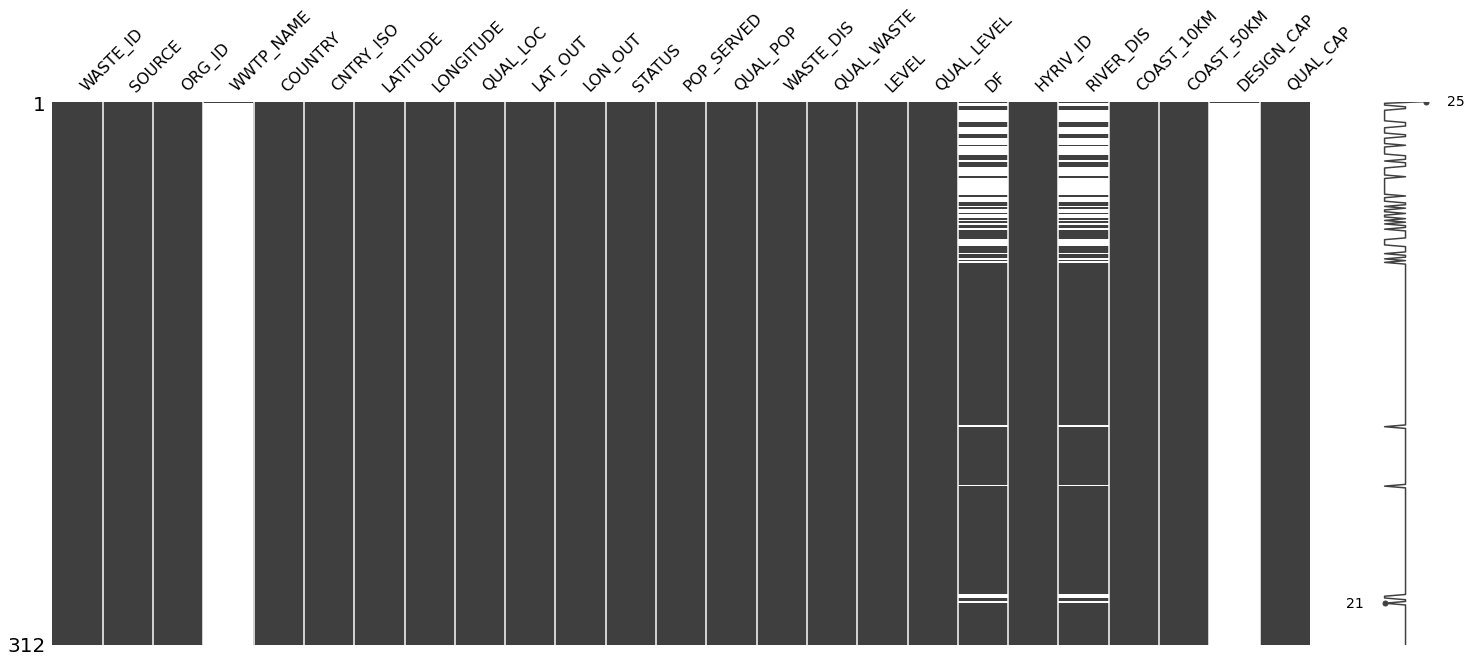

In [7]:
# Identifying patterns in missing values

# MATRIX PLOT (Visualising the distribution of missing data)
# When data is present, the plot is shaded in grey, and when it is absent the plot is displayed in white.
msno.matrix(RawDataframe)

COMMENT OF RESULTS:
>*   No duplicate records, it appears.
>*   There is no data in the WWTP_NAME and DESIGN_CAP columns, except for one strange row to be checked. So far, though, they will have to be all removed.
>*   A direct correlation between the missing values in the DF and RIVER_DIS columns can be easily seen in this image. This will require further assessment to decide whether I remove or fill in the gaps.

### 2.2 Dropping columns and rows

In [8]:
# [COLUMNS]

# I decided to remove columns one by one instead of a direct selection of the columns to be used in my analysis
## because I want to keep records of the reasons for not using the each of them if I want to go back later.
Dataframe = RawDataframe.drop([
    'WWTP_NAME', 'DESIGN_CAP', # Columns missing over 95% of its data
    'SOURCE', 'COUNTRY', 'CNTRY_ISO', 'STATUS', 'LEVEL', # Columns containing 1 unique value
    'QUAL_LOC', 'QUAL_POP', 'QUAL_WASTE', 'QUAL_LEVEL', 'QUAL_CAP', # Quality check columns not relevant for this analysis
    'ORG_ID', 'HYRIV_ID' # Other non-relevant columns
                              ], axis=1)

# [ROWS]

# I noticed that the first row [0] countained records from the WWTP Strzyzow (WASTE ID 2248)
## which is actually located in east Poland, +70km away from the Poland-Ukraine border.
Dataframe.drop(0, inplace=True)

Dataframe.head(1)

,WASTE_ID,LATITUDE,LONGITUDE,LAT_OUT,LON_OUT,POP_SERVED,WASTE_DIS,DF,RIVER_DIS,COAST_10KM,COAST_50KM
1,56448,44.396,33.977,44.39,33.96,22412,1865.016,NaN,NaN,1,1


### 2.4 Renaming columns

I decided to rename the columns to facilitate a better reading and understanding of the codes written from this section now on.

In [9]:
Dataframe.rename(columns={
    'WASTE_ID': 'WWTP_ID', # ID of each wastewater treatment plant (WWTP).
    'POP_SERVED': 'POPULATION_SERVED', # Size of the population served by the WWTP.
    'DF': 'DILUTION_FACTOR', # Estimated dilution factor.
    'WASTE_DIS' : 'WASTEWATER_DISCHARGED', # Treated wastewater discharged by the WWTP in m3.
    'RIVER_DIS' : 'RIVER_DISCHARGED', # Estimated the volume of water flowing through a river channel at the WWTP outfall location in m3.
    'LATITUDE': 'LATITUDE_WWTP', # Latitude of reported WWTP location.
    'LONGITUDE': 'LONGITUDE_WWTP', # Longitude of reported WWTP location.
    'LAT_OUT': 'LATITUDE_OUTFALL', # Latitude of the estimated outfall location.
    'LON_OUT': 'LONGITUDE_OUTFALL' # Longitude of the estimated outfall location.
                         }, inplace=True)

Dataframe.head(1)

,WWTP_ID,LATITUDE_WWTP,LONGITUDE_WWTP,LATITUDE_OUTFALL,LONGITUDE_OUTFALL,POPULATION_SERVED,WASTEWATER_DISCHARGED,DILUTION_FACTOR,RIVER_DISCHARGED,COAST_10KM,COAST_50KM
1,56448,44.396,33.977,44.39,33.96,22412,1865.016,NaN,NaN,1,1


# **3.0 Geodata Pre-processing**
---




### 3.1 Producing Derived Data

**[COASTAL_DISTANCE]**

The COAST_10KM and COAST_50KM columns follow a Boolean methodology to estimate the distance from a WWTP outfall location to the ocean or lake larger than 500km2. In this, values of 0 represent False whereas values of 1 represent True for claims that a particular outfall is within the stated distance (see the image below for better understanding).

Thereupon, to bring this concept to a higher-level language, the logic values of the two columns will be combined to form a categorical group of distances in string format that is easier to understand by all types of audiences.

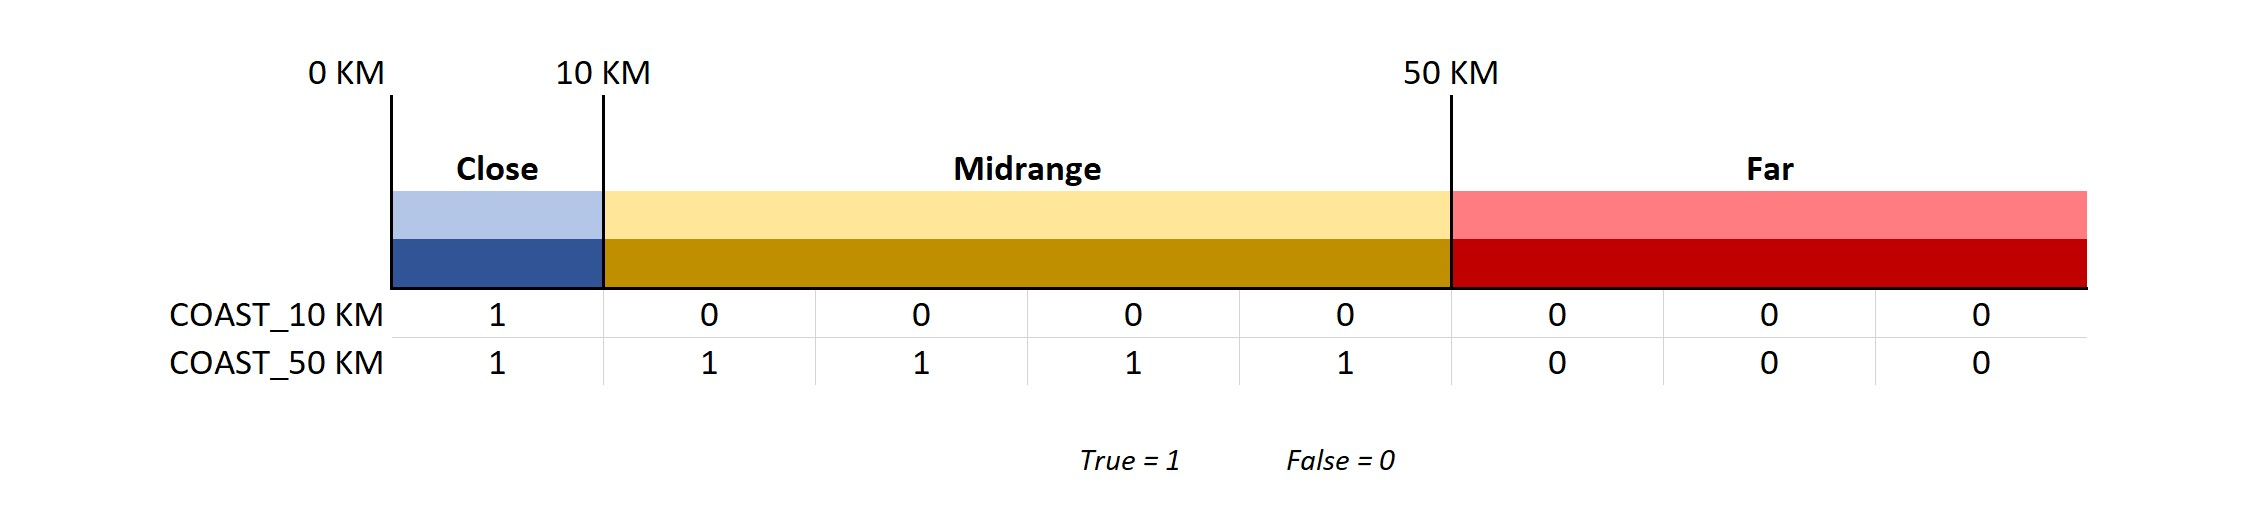

In [10]:
# Creating the conditions
conditions = [
    (Dataframe['COAST_10KM'] == 0) & (Dataframe['COAST_50KM'] == 0), # Far
    (Dataframe['COAST_10KM'] == 0) & (Dataframe['COAST_50KM'] == 1), # Midrange
    (Dataframe['COAST_10KM'] == 1) & (Dataframe['COAST_50KM'] == 1), # Close
    (Dataframe['COAST_10KM'] == 1) & (Dataframe['COAST_50KM'] == 0), # Error (if existent)
             ]

# Creating the category names
values = ['Far', 'Midrange', 'Close', 'Error']

# Assembling them into a new column
Dataframe['COASTAL_DISTANCE'] = np.select(conditions, values)

# Deleting these two columns because they are not necessary anymore.
Dataframe.drop(['COAST_10KM', 'COAST_50KM'], axis=1, inplace=True)

# Counting the elements' frequency to verify the presence of errors
np.unique(Dataframe['COASTAL_DISTANCE'], return_counts=True) 

(array(['Close', 'Far', 'Midrange'], dtype=object), array([ 61, 195,  55]))

**[OUTFALL_DISTANCE]**

In addition, I will create a column with the calculated distances between the WWTPs and their respective outfall areas to produce extra context to the analysis.

In [11]:
# approximate radius of earth in km
R = 6371.0

# calculating the distances and store them in a new column
for i, row in Dataframe.iterrows():
    lat1 = radians(row['LATITUDE_WWTP'])
    lon1 = radians(row['LONGITUDE_WWTP'])
    lat2 = radians(row['LATITUDE_OUTFALL'])
    lon2 = radians(row['LONGITUDE_OUTFALL'])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    Dataframe.at[i, 'OUTFALL_DISTANCE'] = R * c
# rounding up the results
Dataframe['OUTFALL_DISTANCE'] = Dataframe['OUTFALL_DISTANCE'].round(1) 

# display the resulting column
Dataframe[['LATITUDE_WWTP', 'LONGITUDE_WWTP', 'LATITUDE_OUTFALL', 'LONGITUDE_OUTFALL', 'COASTAL_DISTANCE', 'OUTFALL_DISTANCE']].head(2)

,LATITUDE_WWTP,LONGITUDE_WWTP,LATITUDE_OUTFALL,LONGITUDE_OUTFALL,COASTAL_DISTANCE,OUTFALL_DISTANCE
1,44.396,33.977,44.39,33.96,Close,1.5
2,44.410,34.021,44.39,33.96,Close,5.3


**[RISK SCORE] & [CONTAMINATION_RISK]**

In [12]:
# Creating 2 new columns called 'RISK_SCORE' and 'RISK_GROUP' using the `assign` method and a lambda function

# [RISK SCORE]
Dataframe = Dataframe.assign(
    RISK_SCORE=lambda x: (
        x['POPULATION_SERVED'] / x['DILUTION_FACTOR']) / 10)
Dataframe['RISK_SCORE'] = Dataframe['RISK_SCORE'].round(2)

# [RISK GROUP]
Dataframe['CONTAMINATION_RISK'] = Dataframe['DILUTION_FACTOR'].apply(lambda x: 'Very High'  if x <=10
                                                                  else 'High'       if x >= 10  and x <= 100
                                                                  else 'Acceptable'      if x >= 101  and x <= 50_000
                                                                  else 'Sustainable'     if x >= 100_001
                                                                  else 'Near Outfall Area')
Dataframe[['RISK_SCORE', 'CONTAMINATION_RISK']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311 entries, 1 to 311
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RISK_SCORE          250 non-null    float64
 1   CONTAMINATION_RISK  311 non-null    object 
dtypes: float64(1), object(1)
memory usage: 15.4+ KB


### 3.2 Reverse Geocoding

Because of the lack of data on names for the treatment plants or the regions in which they are located in, I found it necessary to make use of an API to convert their coordinates (latitude and longitude) and assign them to human-readable place names to provide more geographical context and additional information about the locations involved in the analysis. Also, it enables me to match my DataFrame to the GeoDataFrame through the regions names (if needed) and provide some insights using aggregation.

Therefore, I will be generating a column for the macroregions (states and capital city) and the microregions of each WWTP. The data classification for these microregions can vary a lot due to poor Ukranian geodata provided by most of the available APIs I tried to use (Google, OpenStreetMap...), so I will emcompass names of villages, towns, cities, municipalities, boroughs, counties, and districts, with the purpose of just to approximately narrowing down the geographical context from a national to a regional level.

[PART 1: SOURCING]

In [ ]:
# Generating a progress bar, number of iterations, time taken to run the loop, and frequency of iterations per second,
## so I can monitor the performance of this code.
tqdm.pandas()

#  Creating a geocoder object
locator = Nominatim(user_agent='Google', timeout=10)

# Function for reverse geocoding to extract data based on key-words
def georeverse (row):
    coordinates = f"{row['LATITUDE_WWTP']}, {row['LONGITUDE_WWTP']}"
    location = locator.reverse(coordinates, language='en', exactly_one=True)
    # Keyword-based extraction
    address = location.raw['address']
    village = address.get('village', '')
    town = address.get('town', '')
    city = address.get('city', '')
    municipality = address.get('municipality', '')
    borough = address.get('borough', '')
    county = address.get('county', '')
    district = address.get('district', '')
    macroregion = address.get('state', '')
    # Row iteration for each created column
    row['VILLAGE'] = village
    row['TOWN'] = town
    row['CITY'] = city
    row['MUNICIPALITY'] = municipality
    row['BOROUGH'] = borough
    row['COUNTY'] = county
    row['DISTRICT'] = district
    row['MACROREGION'] = macroregion
    return row
Dataframe = Dataframe.progress_apply(georeverse, axis=1)

  0%|          | 0/311 [00:00<?, ?it/s]

[PART 2: COMBINING EXTRACTED DATA]

In [ ]:
# The priority of overlaying data here will follow a rule aimed at generating
## as many unique values as possible. So it will follow the order according to the formula below,
### with the columns overlapping from top to bottom (or from left to right in the data frame).

def combine_columns (row):
  if row['VILLAGE'] != '':
    return row['VILLAGE']
  elif row['TOWN'] != '':
      return row['TOWN']
  elif row['CITY'] != '':
      return row['CITY']
  elif row['MUNICIPALITY'] != '':
      return row['MUNICIPALITY']
  elif row['BOROUGH'] != '':
      return row['BOROUGH']
  elif row['COUNTY'] != '':
      return row['COUNTY']
  else:
    return row['DISTRICT']
Dataframe['MICROREGION'] = Dataframe.apply(combine_columns, axis=1)


Dataframe[['VILLAGE', 'TOWN', 'CITY', 'MUNICIPALITY', 'BOROUGH', 'COUNTY', 'DISTRICT', 'MICROREGION', 'MACROREGION']]

[PART 3: CLEANING]

As I expected, some of the data extracted will need some manual adjustments.

In [ ]:
# Typo ajustment to match the basemap name
Dataframe.loc[(Dataframe['MACROREGION'] == 'Kyiv Oblast'),['MACROREGION']] = 'Kiev Oblast'
Dataframe.loc[(Dataframe['MACROREGION'] == 'Odesa Oblast'),['MACROREGION']] = 'Odessa Oblast'

# I also spotted one of the WWTPs with a state named 'Lublin Voivodeship', which is located on
## the border of Poland with the Volyn Oblast (UKR), despite the WWTP being classified as Ukrainian.
Dataframe.loc[(Dataframe['MACROREGION'] == 'Lublin Voivodeship'),['MACROREGION']] = 'Volyn Oblast'


# There are duplicate classifications for the Crimean region, so I'll use it for basemap name version.
## Also, to follow the basemap classification, I'll assign Sevastopol's locations to the Crimean Peninsula
Dataframe.loc[(Dataframe['MACROREGION'] == 'Republic of Crimea'),['MACROREGION']] = 'Autonomous Republic of Crimea'
Dataframe.loc[(Dataframe['MACROREGION'] == 'Sevastopol'),['MACROREGION']] = 'Autonomous Republic of Crimea'


# The records here refer for the capital city of Kyiv located in the Kiev Oblast
Dataframe.loc[(Dataframe['MACROREGION'] == '') & (Dataframe['MICROREGION'] == 'Kyiv'),['MACROREGION']] = 'Kiev Oblast'

# Some WTTPs in the Crimean Peninsula did not have any data, so I'm tracking those based on coordination limits
## for the area to assign the macroregion. But microregions will remain as uknown because they are in desolate areas.
Dataframe.loc[(Dataframe['LONGITUDE_WWTP'] >= 32.5
  ) & (Dataframe['LONGITUDE_WWTP'] <= 36.6
   ) & (Dataframe['LATITUDE_WWTP'] >= 44.4
    ) & (Dataframe['LATITUDE_WWTP'] <= 45.5
     ) & (Dataframe['MACROREGION'] == ''
      ) & (Dataframe['MICROREGION'] == ''
       ), ['MACROREGION']] = 'Autonomous Republic of Crimea'

Dataframe.loc[(Dataframe['MACROREGION'] == 'Autonomous Republic of Crimea'
  ) & (Dataframe['MICROREGION'] == ''
   ), ['MICROREGION']] = 'Unknown'

# And after all that, I can discard any columns not anymore necessary
Dataframe = Dataframe.drop(['VILLAGE', 'TOWN', 'CITY', 'MUNICIPALITY', 'BOROUGH', 'COUNTY', 'DISTRICT'], axis=1)

COMMENT ON RESULTS:

>*   For the scope of this analysis only, I am satisfied with the amount of data gathered. Since the purpose of this section is just to provide additional context to analysis generated from other key data.








### 3.3 GeoDataFrame Conversion

A GeoDataFrame is a tabular data structure that contains a GeoSeries, which is similar to a Pandas DataFrame but with a geometry column for storing geometry data such as points, lines, and polygons. This column is generated by converting the spatial data (latitude and longitude) in the DataFrame to a format that can be used by a geometry library (GeoPandas), usually involving the creation of a geometry object and storing it in the column. This will then allow me to perform spatial operations on the data, such as calculating intersecting points and polygons, and more. 

[PART 1: GEOMETRY COLUMN]

In [ ]:
# Zipping Latitude (x) and Longitude (y) coordinates into a single feature
geometry = [Point(xy) for xy in zip(Dataframe['LONGITUDE_WWTP'], Dataframe['LATITUDE_WWTP'])]
geometry_o = [Point(xy) for xy in zip(Dataframe['LONGITUDE_OUTFALL'], Dataframe['LATITUDE_OUTFALL'])]

# Creating GeoPandas dataframe and designating a coordinate system
Dataframe = gpd.GeoDataFrame(Dataframe, crs = 'epsg:4326', geometry = geometry)
DataframeOutfall = gpd.GeoDataFrame(Dataframe, crs = 'epsg:4326', geometry = geometry_o)


DataframeOutfall.head(1)

[PART 2: SPATIAL JOIN]

Moreover, I will be performing a spatial join to combine data from two my main data frame and the basemap based on their spatial relationship by finding all the points in the data frame that are within a certain polygon in the basemap. This can be useful for visualizing the statistical data on the map or for performing further spatial analyses.

In [ ]:
# Copying the values from the 'MACROREGION' column to 'name' column to work as the intersect column key in both data frames
Dataframe['name'] = Dataframe['MACROREGION'].copy()

# Merging the two dataframes on the 'name' column
GeoJoin = pd.merge(Dataframe, Basemap, on='name')

# Setting the geometry column of the merged dataframe to be 'geometry_y', using the EPSG:4326 coordinate system
GeoJoin.set_geometry('geometry_y', inplace=True, crs='epsg:4326')


GeoJoin.head(2)

### 3.5 Final Version

In [ ]:
Dataframe

1.    The new cleaned version of the data frame has been modified to remove unnecessary columns, rename most columns to be more descriptive, and modify the values in certain columns to be more accurate and consistent.

2.   It contains now a few new columns, such as 'MACROREGION' and 'MICROREGION', which contain names for geolocations that are based on the latitude and longitude values of WWTPs. Also, the addition of the 'geometry' column also will allow for more powerful analysis and visualization of the data.

# **4.0 Exploration**
---




After being done will all pre-processing requirements, I'll conduct a basic exploration as a first step on the analysis, which is designed to provide a broad overview of the data and identify potential patterns and trends.

This will involve techniques, such as summary statistics to understand the central tendency of values, multivariate correlation to calculate the relationship between multiple variables, and using plots to identify clusters or groups within the data.

### 3.1 Summary Statistics

But first, I have to deal with those missing values spotted earlier on in the **2.1 Diagnosticing data issues**. But, since I'm working with spatial data, I believe I must be inclusive of all data contained in the dataframe, as even outliers can actually represent important spatial patterns or trends that could be lost if removed.

Therefore, I will be referring here to the scientific study by [Ehalt Macedo, et al. (2022)](https://essd.copernicus.org/articles/14/559/2022/#section4) which assigned infinite values for dilution factors where the outfall location ranges within 10km and coincides with the ocean or a large lake. And since there is no meaningful value for direct river discharges in these locations, the related records for both columns were preferred to remain empty to avoid assigning misleading or biased values. 

Moreover, when considering that larges lakes have traditionally been important sources of water for human populations, modern technology has made it also possible for people to access water from a variety of sources, including oceans by the use of desalination processes that enable seawater to be converted into fresh drinking water. Thus, for the purpose of exclusively statistical analysis, I would create an alternative data frame and filter out the records that are part of the 'Close' category of COASTAL_DISTANCE to guarantee a more accurate evaluation of the groups of values in each type of analysis.

In [ ]:
# Filtering out the group that contains missing values
StatsDataframe = Dataframe.loc[(Dataframe['COASTAL_DISTANCE'] != 'Close')]

# Retrieving a complete statistical summary for columns containing only statistical and categorical values.
StatsDataframe.loc[:,['POPULATION_SERVED', 'WASTEWATER_DISCHARGED', 'DILUTION_FACTOR', 'RIVER_DISCHARGED', 
                      'COASTAL_DISTANCE', 'OUTFALL_DISTANCE','MACROREGION', 'MICROREGION']].describe(include='all')

COMMENT ON RESULTS:

>*   27 Ukrainian states like the official number, CHECK. 2 categories for Outfall Distance after applying a filter, also CHECK.
>*   Dilution factor numbers vary widely from minimum to maximum, with the bottom 25% falling into high contamination risk levels.
>*   There is a huge discrepancy between the values in m3 of discharge of treated sewage and river flows, indicating that in general, Ukrainian rivers may not be able to effectively dilute effluents from treatment plants.








### 3.3 Correlation Analysis

In [ ]:
# Setting the size and ration of the visual
plt.figure(figsize= (18, 8))

# Generating a mask for the upper triangle
mask= np.triu(
    np.ones_like(StatsDataframe[
                  ['POPULATION_SERVED', 'WASTEWATER_DISCHARGED', 
                  'DILUTION_FACTOR', 'RIVER_DISCHARGED']
                            ].corr(),dtype= bool))

# Setting the visual with a range of values to be displayed on the colormap from -1 to 1,
## and set the annotation to True to display the correlation values on the heatmap.
sns.heatmap(StatsDataframe[
            ['POPULATION_SERVED', 'WASTEWATER_DISCHARGED', 
             'DILUTION_FACTOR', 'RIVER_DISCHARGED']
                          ].corr(),
            mask= mask, vmin= -1, vmax= 1, annot= True, cmap= 'BrBG')

COMMENT OF RESULTS:
>*   Levels of treated-wastewater discharge are in perfect correlation with sizes of population served by each WWTP. But this is explained by the attribute being a population-based estimation made by Ehalt Macedo, et al. (2022, see section 2.1.4) to fix missing reported data issues and ensure consistency throughout the dataframe.
>*   The dilution factor, on the other hand, has some correlation with river discharges, as it increases more rapidly as more m3 of water flows through the rivers than with treated wastewater discharged into them.


# **5.0 Regional Analysis**
---




### 4.1 Population Distribution

This section will involve studying the quality and accessibility of drinking water in different regions of Ukraine. This type of analysis is important because it can help identify areas where access to safe water is limited or inadequate, and can help policymakers and other stakeholders to develop strategies to improve access to water in these areas.

By comparing data across different regions, I can then identify trends and patterns in water management and identify factors that may be contributing to disparities in safe water access. This information can be used to develop targeted interventions and policies that aim to improve access to safe water for the local population.

Ukraine is a densely populated country, with the majority of its population concentrated in the central, southern and eastern regions. With that being said, a thorough geospatial analysis of the population distribution will help to identify areas of highest wastewater contamination risk.

So, how is the distribution of the population served by state?

In [ ]:
#@title [V] Data Aggregation
# Grouping the total of the population served by macroregion
GeoJoin_Sum = GeoJoin.groupby('name').agg('sum')

# Merging the aggregated population data with the Basemap dataframe based on the 'name' column
GeoJoin_Sum = pd.merge(GeoJoin_Sum, Basemap, on='name')

# Converting the resulting dataframe back to a GeoDataFrame
GeoJoin_Sum = gpd.GeoDataFrame(GeoJoin_Sum)

In [ ]:
#@title [V] Map
# Creating figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30, 10))
GeoJoin_Sum.plot(ax=ax,
                 column='POPULATION_SERVED',
                 cmap='Blues', alpha=0.8,
                 linewidth=0.8, edgecolor='0.2')

# Adding title and labels with the names of each region
ax.set_title("Population Size Per Macro Region", fontsize=30, color='DarkBlue')
for index, row in GeoJoin_Sum.iterrows():
    ax.text(row['geometry'].centroid.x, row['geometry'].centroid.y, row['name'], fontsize=9)

# Creating colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(
                                            vmin=GeoJoin_Sum['POPULATION_SERVED'].min() ,
                                            vmax=GeoJoin_Sum['POPULATION_SERVED'].max() ))
sm._A = [] # empty array for the data range
cbar = fig.colorbar(sm) # adding the colorbar to the figure
ax.axis('off') # removing the axis

# Formating the tick labels on the colorbar
formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))
cbar.ax.yaxis.set_major_formatter(formatter)

In [ ]:
#@title [V] Queries
# QUERY 1:WHAT IS THE TOTAL POPULATION SERVED IN UKRAINE?
query1 = GeoJoin_Sum.assign(region='Ukraine')
query1 = query1.groupby('region')['POPULATION_SERVED'].sum()
query1 = query1.reset_index().rename(columns={'region': 'name'})
query1 = query1.assign(QUERY='Total population of the WWTP network:')
#__________________________________________________________________________________________
# QUERY 2: WHAT IS THE SUMMED POPULATION OF ALL EASTERN MACROREGIONS?
query2 = GeoJoin_Sum.loc[GeoJoin_Sum['name'].isin(['Dnipropetrovsk Oblast', 'Kharkiv Oblast', 'Donetsk Oblast', 'Luhansk Oblast'])].assign(region='East Regions')
query2 = query2.groupby('region')['POPULATION_SERVED'].sum()
query2 = query2.reset_index().rename(columns={'region': 'name'}).assign(QUERY='Total population of the east Ukraine:')
#__________________________________________________________________________________________
# QUERY 3: AND WHAT ABOUT THE WHOLE SOUTH REGION?
query3 = GeoJoin_Sum.loc[GeoJoin_Sum['name'].isin(['Odessa Oblast', 'Mykolaiv Oblast', 'Kherson Oblast',
                                                   'Autonomous Republic of Crimea', 'Zaporizhia Oblast'])].assign(region='South Regions')
query3 = query3.groupby('region')['POPULATION_SERVED'].sum()
query3 = query3.reset_index().rename(columns={'region': 'name'}).assign(QUERY='Total population of the south Ukraine:')
#__________________________________________________________________________________________
# QUERY 4: WHICH MACROREGION HAS THE HIGHEST POPULATION SERVED?
query4 = GeoJoin_Sum[GeoJoin_Sum.POPULATION_SERVED == GeoJoin_Sum.POPULATION_SERVED.max()]
query4 = query4.assign(QUERY="Country's most populous macroregion:")
#__________________________________________________________________________________________
# QUERY 5: WHAT IS THE MOST POPULOUS MACROREGION IN WESTERN UKRAINE?
query5 = GeoJoin_Sum[GeoJoin_Sum.name == 'Lviv Oblast']
query5 = query5.assign(QUERY='Largest concentration in western Ukraine:')
#__________________________________________________________________________________________
# Stacking the dataframes
queries = pd.concat([query1, query2, query3, query4, query5])

# Creating a PERCENTAGE_SERVED column
total_population = GeoJoin_Sum['POPULATION_SERVED'].sum()
queries = queries.assign(PERCENTAGE_SERVED=queries['POPULATION_SERVED'].apply(lambda x: (x / total_population) * 100 )).round(1)

# Formatting the values in the POPULATION_SERVED column with commas as thousand separators
queries['POPULATION_SERVED'] = queries['POPULATION_SERVED'].apply(lambda x: "{:,}".format(x)) 

# Printing the results
queries[['QUERY', 'name', 'POPULATION_SERVED', 'PERCENTAGE_SERVED']]

COMMENT ON RESULTS:

>*   From all the insights observed, it is clear that the eastern and southern regions of Ukraine are integral parts of the WWTP network, serving together over half of the total connected population.  These regions are crucial to the proper functioning of the network and their importance cannot be overstated.

>*   On the other side of Ukraine, the Kiev Oblast, home of the capital city Kiev and located in the north, serves alone 14.4% of the population. And the Lviv Oblast, while not as crowded, still plays a significant role in the west, serving nearly 5% of the total network.

>*   In short, these mentioned regions together account for nearly 75% of the connected population, highlighting the vital role they play in serving the needs of the country.

Also, it is important to note that the size of the populations served in these regions has a significant impact on the overall performance of the WWTP network. With a larger number of people relying on the network for wastewater treatment, it is essential that these areas are given the necessary resources and attention to ensure that the network is functioning at its best.

### 4.2 Hydrographic Scenario

Using logarithms can be helpful for visualizing data with a large range of values because it can compress the range of the data into a more manageable range, making the relationship between the values more clear and easier to interpret, especially when comparing variables with different scales. Additionally, using logarithms can help to highlight patterns or trends in the data that might not be immediately apparent when using a linear scale.

In [ ]:
#@title [V] Map
# Creating figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30, 10))
ax.set_title("River Discharge Volume in m3 Per Macro Region", fontsize=30, color='DarkGreen')
GeoJoin_Sum.plot(ax=ax, column='RIVER_DISCHARGED', cmap='BrBG', alpha=0.75, linewidth=0.8, edgecolor='0.1')

# Creating colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='BrBG', norm=plt.Normalize(vmin=GeoJoin_Sum['RIVER_DISCHARGED'].min(), vmax=GeoJoin_Sum['RIVER_DISCHARGED'].max() ))
sm._A = [] # empty array for the data range
cbar = fig.colorbar(sm) # adding the colorbar to the figure
ax.axis('off') # removing the axis

# Formating the tick labels on the colorbar
formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))
cbar.ax.yaxis.set_major_formatter(formatter)

In [ ]:
#@title [V] Bar Chart
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(25, 10))
sns.barplot(x=GeoJoin_Sum['RIVER_DISCHARGED'], y='name', data=GeoJoin_Sum.nlargest(10, 'RIVER_DISCHARGED'),
            label='River Volume', color='g', palette='light:#065_r')

# Customizing the visual
sns.set_theme(style="whitegrid") # background style
plt.title('River Volume Comparison in m3', fontsize=30) # setting title
plt.tick_params(axis='both', which='major', labelsize=20) # setting label font sizes
ax.set(ylabel='', xlabel='') # no labels
sns.despine(left=True, bottom=True) # less grids

COMMENT ON RESULTS:

>*   The distribution of potable water in Ukraine has proven to vary greatly among different regions of Ukraine. In general, the central and south-western regions appear to have better access to water than all other regions. However, even in these there are disparities in water availability, because urban areas (assumed due to populations sizes) have demonstrated better access to water than rural areas. In addition, the water infrastructure in Ukraine is often outdated and in need of repair, which can lead to water shortages and water contamination ([UNICEF, 2022](https://www.unicef.org/ukraine/en/water-sanitation-and-hygiene-wash)).

In [ ]:
# Generating a scatter plot visualisation to emcompass the treatment plants with the lowest dilution factors
Scatterplot = px.scatter(Dataframe, x=np.log10(Dataframe['RIVER_DISCHARGED']),
                 y=np.log10(Dataframe['DILUTION_FACTOR']),
                 color='CONTAMINATION_RISK', symbol='CONTAMINATION_RISK',
                 marginal_x='histogram', trendline='ols',
                 hover_data=['WWTP_ID', 'MACROREGION', 'MICROREGION', 'RIVER_DISCHARGED', 'DILUTION_FACTOR'],
                 labels=dict(x='RIVER STRENGTH SCALE', y='DILUTION FACTOR SCALE'))

Scatterplot.show()

COMMENT ON RESULTS:
>*   [TEXT HERE]

In addition, with the table below we can conclude that outfall areas located within 10 to 50 km of larger bodies of water benefit from an average volume of river flow 12 times greater than those located further away.

Tipically, this is because rivers closer to the coast are fed by larger watersheds, which means they have more water flowing into them from tributaries and other sources. So, this clearly impacts on the dilution levels of treated-wastewater discharges into those rivers, which are washed away to the large water bodies more quickly.

In [ ]:
TestDf = Dataframe.fillna(0)

TestDf[['COASTAL_DISTANCE', 'POPULATION_SERVED', 'WASTEWATER_DISCHARGED', 'RIVER_DISCHARGED' , 'DILUTION_FACTOR']
          ].groupby('COASTAL_DISTANCE'
            ).agg('sum'
              ).astype(int)

### Ingisht

And we can look deeper below and see that there are single WWTPs in these regions serving populations of over 300 thousand people — *2 of them very close to contamination risk levels with low dilution factors*.

In [ ]:
Dataframe[['MACROREGION', 'MICROREGION', 'WWTP_ID', 'POPULATION_SERVED', 'RIVER_DISCHARGED', 'DILUTION_FACTOR', 'COASTAL_DISTANCE']
          ].sort_values('POPULATION_SERVED', ascending=False
                        ).round().head(5)

### 4.3 Regional Priorities


According to [Ehalt Macedo, et al. (2020, section 2.1.4)](https://essd.copernicus.org/articles/14/559/2022/#section4), the minimum dilution factor recommended European Medicines Agency (EMA) for environmental risk assessments of medicinal products for human use is 10. However, in reality lots of streams receive wastewater higher than they can carry away, representing often DF values equal or lower than 3.

That being said, 

```
Risk Score =   Population Served ÷ Dilution Factor

High Risk Score: Volume and quality of water less consistent with the size of the population.
Low Risk Score: Volume and quality of water more consistent with the size of the population.

```

Using the priority list of regions with highest contamination risk, it is possible to target areas for improved wastewater management.

In [ ]:
fig, ax = plt.subplots(1, figsize=(30, 10)) # Creating figure and axes for Matplotlib
GeoJoin_Sum.plot(ax=ax, column='RISK_SCORE', cmap='RdGy_r', alpha=0.75, linewidth=0.8, edgecolor='0.1') # Plotting the map
sm = plt.cm.ScalarMappable(cmap='RdGy_r', norm=plt.Normalize(vmin=GeoJoin_Sum['RISK_SCORE'].min(), vmax=GeoJoin_Sum['RISK_SCORE'].max())) # Creating colorbar as a legend
sm._A = [] # empty array for the data range
cbar = fig.colorbar(sm) # adding the colorbar to the figure
ax.axis('off') # removing the axis
formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)) # 1.1 Formating the tick labels on the colorbar
cbar.ax.yaxis.set_major_formatter(formatter) # 1.2 Formating the tick labels on the colorbar

In [ ]:
# Grouping the DataFrame by the 'RISK_GROUP' column and aggregating the other variables
Dataframe.groupby('RISK_GROUP').agg({
                                    'RISK_GROUP': 'count', 'DILUTION_FACTOR': 'mean', 'POPULATION_SERVED': 'sum', 'RISK_SCORE': 'mean'}
                                      ).rename(columns={'RISK_GROUP': 'Count Of WWTPs', 'DILUTION_FACTOR': 'Average Dilution Factor',
                                                        'POPULATION_SERVED': 'Total Population Served', 'RISK_SCORE': 'Average Risk Score'}).round(1)

In [ ]:
# Binning a variable with uneven distribution and specifying the labels
StatsDataframe['RIVER_FLOW'] = pd.cut(StatsDataframe['RIVER_DISCHARGED'], bins=4, labels=['Low', 'Medium', 'High', 'Very High'])
StatsDataframe.groupby(StatsDataframe['RIVER_FLOW']).mean().round()

In [ ]:
# Binning a variable with uneven distribution and specifying the labels
bins = pd.cut(StatsDataframe['DILUTION_FACTOR'], bins=4, labels=['Low', 'Medium', 'High', 'Very High'])
StatsDataframe.groupby(bins).mean().round()

# **6.0 Conclusion**
---




1.   Idea 1
2.   Idea 2

Last paragraph: Overall, the distribution of potable water in Ukraine is uneven, with some regions and population groups having better access than others. Improving access to clean drinking water is an important goal for the country, and efforts to improve water infrastructure and address water shortages must keep ongoing.

# **7.0 References**
---




*   Ehalt Macedo, H., Lehner, B., Nicell, J., Grill, G., Li, J., Limtong, A., and Shakya, R.: Distribution and characteristics of wastewater treatment plants within the global river network, Earth Syst. Sci. Data, 14, 559–577, https://doi.org/10.5194/essd-14-559-2022, 2022.
*   Environmental Medicines Agency (EMA): Guideline on the environmental risk assessment of medicinal products for human use: available at: https://www.ema.europa.eu/en/environmental-risk-assessment-medicinal-products-human-use#current-version-section (last access: December 2019), 2006. 

### 4.? Wastewater Treatment Plants

In [ ]:
ScatterMapbox = px.scatter_mapbox(Dataframe, lat='LATITUDE_WWTP', lon='LONGITUDE_WWTP',
                                  color=Dataframe['WASTEWATER_DISCHARGED'],
                                  color_continuous_scale=px.colors.sequential.turbid,
                                  size='POPULATION_SERVED',
                                  hover_name='MICROREGION', hover_data=['MACROREGION', 'POPULATION_SERVED'],
                                  zoom=4.7, center={'lat': 48.5, 'lon': 32})

ScatterMapbox.update_layout(mapbox_style='open-street-map',
                            margin={'r':0,'t':0,'l':0,'b':0})
ScatterMapbox.show()

In [ ]:
fig,ax = plt.subplots(figsize = (15,7.5))
Basemap.plot(ax = ax, color='#2A363B')
DataframeOutfall[DataframeOutfall['COASTAL_DISTANCE'] == 'Close'].plot(ax = ax, markersize = 15, color='#0A9396', marker='*', label = 'Close')
DataframeOutfall[DataframeOutfall['COASTAL_DISTANCE'] == 'Midrange'].plot(ax = ax, markersize = 15, color='#EE9B00', marker='d', label = 'Midrange')
DataframeOutfall[DataframeOutfall['COASTAL_DISTANCE'] == 'Far'].plot(ax = ax, markersize = 15, color='#D52616', marker='o', label = 'Far')

plt.legend(prop={'size':16})

In [ ]:
# [EAST]
fig, ax = plt.subplots(figsize=(12.5,7))
Basemap.plot(ax=ax, alpha=1,color='#a6a6a6')
Dataframe.plot(column=np.log10(Dataframe['DILUTION_FACTOR']),ax=ax,alpha=0.7, legend=True, markersize=50)

plt.title('East') # set latitiude and longitude boundaries for map display
plt.xlim(34,40.3) # 20,42.5 
plt.ylim( 46.5,51) # 44,53

# [WEST]
fig, ax = plt.subplots(figsize=(12.5,7))
Basemap.plot(ax=ax, alpha=1,color='#a6a6a6')
Dataframe.plot(column=np.log10(Dataframe['DILUTION_FACTOR']),ax=ax,alpha=0.7, legend=True, markersize=50)

plt.title('West')
plt.xlim(22.2,29.8) # 20,42.5
plt.ylim(47.7,52) # 44,53

# [CRIMEA]

fig, ax = plt.subplots(figsize=(12.5,7))
Basemap.plot(ax=ax, alpha=1,color='#a6a6a6')
Dataframe.plot(column=np.log10(Dataframe['DILUTION_FACTOR']),ax=ax,alpha=0.7, legend=True, markersize=50)

plt.title('Crimea')
plt.xlim(32.4,36.7) # 20,42.5
plt.ylim( 44.3,46) # 44,53

plt.show()

# **NOTES**
---



### **Cool Usable Codes**



*   ***Seaborn Pair Plot with Hue*** (Multivariate Analysis; Multi plot charts)
        sns.pairplot (data = dataframe, hue = 'column1')
*   ***NumPy Filling Null Values*** (Replace missing data in the dataframe)
        df = df.fillna(0) # Or whatever the string or data type you want
        df['gdp_per_capita'] = np.where(df['column1']!=, df['gdp'] / df['population'], 0] # creating a new column by dividing gdp per population
*   For average-flow conditions, the median calculated DF among the analyzed WWTPs in HydroWASTE (47 302) is 570, but 2533 (5.4 %) of the plants had a DF value below 10, i.e., lower than the recommended threshold for environmental regulations (EMA, 2006). For low-flow conditions, the median DF decreases to 203, and the number of WWTPs having a value below 10 increases to 5712 (12.1 %).
        Insert code


### Links To Go Back Later

*   [Distribution and characteristics of wastewater treatment plants within the global river network](https://essd.copernicus.org/articles/14/559/2022/)
*   [Using the missingno Python library to Identify and Visualise Missing Data Prior to Machine Learning](https://towardsdatascience.com/using-the-missingno-python-library-to-identify-and-visualise-missing-data-prior-to-machine-learning-34c8c5b5f009)
*   [Python Jupyter - Insight to Univariate and Multivariate Distribution Plots](https://www.youtube.com/watch?v=vssXHSLSGL4&ab_channel=NomanArshed)
*   [Univariate, Bivariate, and Multivariate Data Analysis in Python](https://medium.com/mlearning-ai/univariate-bivariate-and-multivariate-data-analysis-in-python-341493c3d173#:~:text=Multivariate%20analysis%20is%20a%20more,plot%2C%20with%20Hue%20as%20Approved.)
*   List item






In [ ]:
Dataframe

In [ ]:
Dataframe.to_csv('Dataframe.csv')

In [ ]:
Basemap.to_csv('Ukr.csv')

### BIN

In [ ]:
# Grouping the total of the population served by WWTPs per state
TreemapDf = Dataframe[['MACROREGION', 'POPULATION_SERVED']
                      ].groupby('MACROREGION'
                        ).agg('sum'
                          ).round(
                            ).reset_index()

# Sorting the results by population number
TreemapDf.sort_values(['POPULATION_SERVED'], ascending=False, inplace=True)

# Generating a treemap visualisation to emcompass all the 27 states and display the scale of population sizes
Treemap = px.treemap(TreemapDf, 
                 path=['MACROREGION'], 
                 values='POPULATION_SERVED',
                 color='POPULATION_SERVED',
                 color_continuous_scale='Blues')

Treemap.update_layout(height=400, margin={'r':108,'t':0,'l':0,'b':0})
Treemap.show()

In [ ]:
Scatterplot.update(layout_yaxis_range = [0,200]) # Explain the DF range  [TEXT HERE]
Scatterplot.update(layout_xaxis_range = [0,200000]) # Explain the pop range [TEXT HERE]

In [ ]:
ScatterMapbox = px.scatter_mapbox(StatsDataframe, lat='LATITUDE_OUTFALL', lon='LONGITUDE_OUTFALL',
                                  color=np.log10(StatsDataframe['RIVER_DISCHARGED']), # Log used to fix the color distribution
                                  color_continuous_scale='Blues',
                                  size='RIVER_DISCHARGED',
                                  hover_name="MICROREGION", hover_data=['MACROREGION', 'POPULATION_SERVED'],
                                  zoom=4.6, height=450)

ScatterMapbox.update_layout(mapbox_style='open-street-map',
                            margin={'r':0,'t':0,'l':0,'b':0})
ScatterMapbox.show()

In [ ]:
DensityMapbox = px.density_mapbox(StatsDataframe, lat='LATITUDE_OUTFALL', lon='LONGITUDE_OUTFALL',
                        z=np.log10(StatsDataframe['RIVER_DISCHARGED']), 
                        color_continuous_scale=px.colors.sequential.Blues, radius=20,
                        labels={"z": 'River Strength'},
                        hover_name='MICROREGION', hover_data=['RIVER_DISCHARGED', 'MACROREGION'],
                        zoom=4.6, center={'lat': 48.5, 'lon': 32}
                        )

DensityMapbox.update_layout(mapbox_style='open-street-map',
                            margin={'r':0,'t':0,'l':0,'b':0})

DensityMapbox.show()

In [ ]:
import squarify





# create a plot figure with figsize and we don't require the axis values so lets remove it
plt.figure(figsize=(25, 10))
plt.axis("off")

GeoJoin_Sum[['POPULATION_SERVED']].sort_values(by=['POPULATION_SERVED'], ascending=False, inplace=True)

# Visual
axis = squarify.plot(
		sizes=GeoJoin_Sum['POPULATION_SERVED'],
		label=GeoJoin_Sum['name'], value=GeoJoin_Sum['POPULATION_SERVED'],
		alpha=0.7,
		pad=0.2,
		text_kwargs={'fontsize': 11})

In [ ]:
print(GeoJoin_Sum[['name', 'POPULATION_SERVED']].sort_values(by=['POPULATION_SERVED'], ascending=False))